# Tutorial on DER Hosting Capacity | <font color=red>Part 3</font>: Volt-Watt Control and PV Hosting Capacity of LV Networks

## 1. Introduction 

### Objectives 
The objectives of this tutorial are:
1. To familiarise with the process by which power engineers can **assess the effects of the Volt-Watt control function (available in most residential PV inverters and used by most standards around the world) on voltages and, thus, on PV hosting capacity.**

2. To continue familiarising with the advanced tool [OpenDSS](https://www.epri.com/pages/sa/opendss) (using Python and the [DSS-Python](https://github.com/dss-extensions/DSS-Python) module). And, to guide you, all will be done using a notebook on [Jupyter Notebook](https://jupyter.org/).

### Structure of this Notebook
The rest of this notebook is divided into three parts:

- **2. Tutorial.** You will learn how to model the Volt-Watt control function using a simple network.
- **3. Exercises.** Here you will go through some exercises that will help you familiarise with the code and how to modify it for different purposes.
- **4. Simulation Workspace.** Here you can place all your code to run it at once. You should use **`code`** that is relevant to each exercise.

<font color='red'>**<u>Note</u>:**</font> Make sure to understand well how to model the network, particularly how to model the PV inverter Volt-Watt control function (2. Tutorial) as this is crucial to go through the exercises. If you make a mistake when modelling the network, your results will be incorrect.

## 2. Tutorial   

We will first create the simple LV network shown in the figure below. We have a transformer (11kV/0.4kV), a three-phase line connecting bus A with bus B, and three single-phase lines connecting bus B with buses C, D, and E. Buses C, D, and E represent the connection points of three different houses.
* The 11kV and 0.4kV are line-to-line nominal values. Thus, the single-phase houses will have a nominal line-to-neutral value of 230V.


<center> <img style="float: middle;" src="Figure_1.png" width="40%"> </center>

**<center>Figure 1. Simple LV Network</center>**

**The Volt-Watt Control Function**. It operates by setting a power output limit as a function of the grid voltage (at the connection point of the PV inverter). As the voltage increases or decreases, the power output of the PV system is adjusted accordingly. The function is usually defined by two parameters: the slope and the intercept. The slope determines the rate at which the power output decreases as the voltage increases, while the intercept sets the power output limit at a specified voltage (Fig.2). As it can be seen in the figure, **there are four setpoints (each with X [voltage] and Y [generation] coordinates) that define how the Volt-Watt control function behaves**.

<center> <img style="float: middle;" src="Figure_2.jpg" width="40%"> </center>

**<center> Figure 2. Volt-Watt Control Function</center>** 


<font color='purple'>**<u>Tech Note</u>:**</font> The PV inverter senses voltages where it is located. But this could be many meters away from the connection point to the grid (where the energy meter or smart meter is). Imagine a big house. This means that the voltage seen by the inverter is likely to be higher than that at the grid connection point (due to the impedance).

Follow the steps below. **And let's begin!**

<font color='red'>**<u>Note</u>:**</font> You will need to run the code in each cell. Select the code cell (a <font color='green'>**green box [ ]**</font> surrounding the cell will appear) and then click on the &#9654; **`Run`** button on top of the page to run the corresponding code (or use the shortcut `Control`-`Enter`). Since you will be running code, **you will need to run the cells sequentially**, one after the other without skipping code cells. A number will appear inside the brackets [X] indicating the number of the *run*.

### 2.1 Load Modules and Libraries
First, we need to run the code below to load the modules and the libraries that will be used in this Tutorial. The purpose of these modules and libraries is:

* **os:** Operating system module, it will be used to get the directory path.
* **dss:** Module for interfacing Python code with OpenDSS. Here is more info about [DSS-Python](https://github.com/dss-extensions/DSS-Python) and other [DSS Extensions](https://dss-extensions.org/).
* **matplotlib.pyplot:** Library for creating static, animated, and interactive visualizations in Python
* **numpy:** Library that adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.  
    * The word `as` in the import of both libraries is used to give another shorter name that will be used in the code, such as `plt` and `np`.

<font color='red'>**<u>Note</u>:**</font> If there is an error in this step, that means that some of the modules are not installed in your computer, so go back to the info provided in Part 0 and make sure you have everything installed.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
added_path = ""
if os.getenv("COLAB_RELEASE_TAG"):
    !git clone --depth=1 -q https://github.com/Team-Nando/Tutorial-DERHostingCapacity-3-VoltWatt_LV
    !pip install dss-python==0.15.3
    added_path = '/Tutorial-DERHostingCapacity-3-VoltWatt_LV'
import dss

<a id='4'></a>
### 2.2 Set the working path
Run the code in the cell below to get your working path. As an output you get the location of this notebook in your computer.  

<font color='red'>**<u>Note 1</u>:**</font> Your path should not have spaces. Here is an example with no spaces: `C:\Users\name\Desktop\FolderX`.

<font color='red'>**<u>Note 2</u>:**</font> If you are a MAC user, there may be some errors due to the different use of slash/backslash when defining a path. By changing `/` instead of `\`, you will fix the problem. For instance, you can change `\\Residential..` with `/Residential..`.

<font color='red'>**<u>Note 3</u>:**</font> You should always open the Jupyter Notebook file from the folder that you uploaded to Jupyter Notebook. If you want to continue working later, you can simply save the changes and then open the **.ipynb** file again and continue working from where you left.

In [3]:
my_directory = os.getcwd() + added_path
print(f"The direction is located in the following path: my_directory = {my_directory}")

The direction is located in the following path: my_directory = C:\Users\AAVILAROJAS\Documents\Tutorial-DERHostingCapacity-3-VoltWatt_LV


### 2.3 Set up dss_engine
Before running the code in Python, we need to set up the **dss_engine** which will be used for OpenDSS commands.


In [4]:
dss_engine = dss.DSS
DSSText = dss_engine.Text
DSSCircuit = dss_engine.ActiveCircuit
DSSSolution = dss_engine.ActiveCircuit.Solution
ControlQueue = dss_engine.ActiveCircuit.CtrlQueue
dss_engine.AllowForms = 0

<font color='red'>**<u>Note</u>:**</font> The code corresponding to sections `2.4` to `2.8` below have already been explained in detail in [Part 2: Time-Series Analysis and PV Hosting Capacity of LV Networks](https://github.com/Team-Nando/Tutorial-DERHostingCapacity-2-TimeSeries_LV). So, no further explanations are provided here.

### 2.4 Create the Circuit

In [5]:
DSSText.Command = 'Clear'
DSSText.Command = 'Set DefaultBaseFrequency=50'
DSSText.Command = 'New Circuit.Simple_LV_Network'
DSSText.Command = 'Edit vsource.source bus1=sourceBus basekv=11 pu=1.0 phases=3'

### 2.5 Add the 11kV/0.4kV Transformer  

In [6]:
DSSText.Command = 'New transformer.LVTR Buses=[sourcebus, A.1.2.3] Conns=[delta wye] KVs=[11, 0.433] KVAs=[250 250] %Rs=0.00 xhl=2.5 %loadloss=0 '

### 2.6 Create the linecodes 

In [7]:
DSSText.Command = 'new linecode.240sq nphases=3 R1=0.127 X1=0.072 R0=0.342 X0=0.089 units=km'
DSSText.Command = 'new linecode.16sq nphases=1 R1=1.15 X1=0.083 R0=1.2 X0=0.083 units=km'

### 2.7 Create the 400V and 230V lines

In [8]:
DSSText.Command = 'new line.A_B bus1=A.1.2.3 bus2=B.1.2.3 length=1 phases=3 units=km linecode=240sq'
DSSText.Command = 'new line.B_L1 bus1=B.1 bus2=C.1 length=0.1 phases=1 units=km linecode=16sq'
DSSText.Command = 'new line.B_L2 bus1=B.2 bus2=D.1 length=0.1 phases=1 units=km linecode=16sq'
DSSText.Command = 'new line.B_L3 bus1=B.3 bus2=E.1 length=0.1 phases=1 units=km linecode=16sq'

### 2.8 Connect loads to a bus  
We need to model each single-phase load (each house) according to Figure 1.
* <font color= red>Red house</font> (bus C) will be represented by Load_1 (using <font color= red> phase 1</font>)
* <font color= blue>Blue house</font> (bus D) will be represented by Load_2 (using  <font color= blue> phase 2</font>)
* <font color= limegreen> Green house </font> (bus E) will be represented by Load_3 (using <font color= limegreen> phase 3</font>)  

<center> Table 1. Load Parameters</center>

| Load Name | Phases | Connected bus | Peak Demand (kW) |  PF  |
|:---------:|:------:|:-------------:|:-----------:|:----:|
|   Load_1  |    1   |       C       |      3      | 0.95 |
|   Load_2  |    1   |       D       |      2      | 0.95 |
|   Load_3  |    1   |       E       |      5      | 0.95 |

In [9]:
DSSText.Command = 'new load.Load_1 bus1=C.1 phases=1 kV=(0.4 3 sqrt /) kW=3 pf=0.95 model=1 conn=wye Vminpu=0.85 Vmaxpu=1.20 status=fixed'
DSSText.Command = 'new load.Load_2 bus1=D.1 phases=1 kV=(0.4 3 sqrt /) kW=2 pf=0.95 model=1 conn=wye Vminpu=0.85 Vmaxpu=1.20 status=fixed'
DSSText.Command = 'new load.Load_3 bus1=E.1 phases=1 kV=(0.4 3 sqrt /) kW=5 pf=0.95 model=1 conn=wye Vminpu=0.85 Vmaxpu=1.20 status=fixed'

### 2.9 Select the relevant scenario

To understand the Volt-Watt control function and its effect on customers voltages, we'll be conducting a simulation using three different scenarios:
- **Scenario 1**: No PV systems are connected to the houses
- **Scenario 2**: PV systmes are connected to the houses without Volt-Watt control function
- **Scenario 3**: PV systems are connected to the houses with Volt-Watt control function

These scenarios will be coded as a dictionary named `scenarios`. The dictionary is a powerful data structure in Python where we can store and/or collect values for a specific keys (the key being the scenario, the values being those describing each scenario). As such we will use the variables `pv` (with [1] or without PV [0]), `inv` (inverter with [1] or without [0] control functions), and `inv_ctrl` (Volt-Watt is enabled [true] or not [false]).

- **Scenario 1**: No PV systems are connected to the houses **>>** `pv=0`, `inv=0`, `inv_ctrl=false`
- **Scenario 2**: PV systems are connected to the houses without Volt-Watt control function **>>** `pv=1`, `inv=0`, `inv_ctrl=false`
- **Scenario 3**: PV systems are connected to the houses with Volt-Watt control function **>>** `pv=1`, `inv=1`, `inv_ctrl=true`

In [10]:
scenarios = {1: {"pv": 0, "inv": 0, "inv_ctrl": "false"},
             2: {"pv": 1, "inv": 0, "inv_ctrl": "false"},
             3: {"pv": 1, "inv": 1, "inv_ctrl": "true"}}

def validate_scenario(scenario):
    if scenario not in scenarios.keys():
        raise ValueError(f"Scenario cannot be {scenario}. It can only be 1, 2, or 3")

The next step is to choose which scenario you want to run by changing the value of the variable `scn` (short for scenario). 

- In order to reduce any errors that may happen when changing the `scn` number, two extra lines of code are added to force an exception to occur if the `scn` number is not 1, 2 or 3.

- The values of the scenarios will be stored in the corresponding variables so they can be used later.

<font color='red'>**<u>Note</u>**</font>: In this Tutorial we will only explain **Scenario 3** as the other two scenarios have been investigated in previous tutorials. But you can change `scn` according to the scenario you want to study.

In [11]:
scn = 3 # Change the value of scn to select the scenario you want to run

validate_scenario(scn)

pv = scenarios[scn]["pv"]
inv = scenarios[scn]["inv"]
inv_ctrl = scenarios[scn]["inv_ctrl"]

### 2.10 Set up the Volt-Watt control function
Since we are running the simulation for Scenario 3 (`pv=1`, `inv=1`, `inv_ctrl=true`), all customers will have PV systems and each PV inverter will have the Volt-Watt control enabled. 
- First, you need to add PV systems to the houses. The corresponding details and code have already been provided in [Part 2: Time-Series Analysis of Three-Phase Unbalanced LV Networks](https://github.com/Team-Nando/Tutorial-DERHostingCapacity-2-TimeSeries_LV).
- To model the Volt-Watt control function in OpenDSS, the four setpoints (P1, P2, P3, P4) of the control function (Fig. 2) are given in 2 arrays: `XArray` and `YArray`.
  - The values of the XArray (0.5, 1.095, 1.100, 1.5) are on the x-axis of the Volt-Watt graph.
  - The values of the YArray (1.0, 1.0, 0.0, 0.0) are on the y-axis of the Volt-Watt graph.
  - You can notice that these particular setpoints mean that for voltage magnitudes larger or equal to 1.1 p.u., the PV system does not have any output (the output is set to zero).
- In order to model the inverter control function, we will use two `DSSText.Command` lines: 
    - The first line introduces the Volt-Watt settings (called curve in OpenDSS), consisting of four points, with (x,y) coordinates corresponding to the values of the X and Y arrays.
    - The second line models the inverter control function, where: 
        - `mode=VOLTWATT` sets the mode of the inverter control function. The mode is set to Volt-Watt which means the control adjusts the inverter's active power output in response to changes in voltages.
        - `voltage_curvex_ref=rated` sets the reference voltage for the Volt-Watt curve and it is set to the rated voltage of the system.
        - `voltwatt_curve=vw_curve_1` sets the name of the Volt-Watt curve to be used for the control. Here the curve is called `vw_curve_1`.
        - `DeltaP_factor` sets the scaling factor for the change in active power output (DeltaP) as a function of the change in grid voltage. In this case, the scaling factor is set to 0.1.
        - `voltagechangetolerance` sets the maximum voltage change tolerance for the inverter control. If the voltage change is greater than 0.0001 value, the control will adjust the inverter's active power output.
        - `varchangetolerance` sets the maximum reactive power change tolerance for the inverter control. If the reactive power change is greater than 0.1 value, the control will adjust the inverter's active power output.
        - `enabled={inv_ctrl}` specifies whether the inverter control is enabled or disabled. The string value of `inv_ctrl` is used to set this parameter dynamically using scenarios dictionary.

In [12]:
if pv == 1:
    DSSText.Command = 'new PVSystem.PV1 bus1=C.1 phases = 1 kva = 10 pmpp = 10 pf = 1 kV=(0.4 3 sqrt /) model=1'
    DSSText.Command = 'new PVSystem.PV2 bus1=D.1 phases = 1 kva = 10 pmpp = 10 pf = 1 kV=(0.4 3 sqrt /) model=1'
    DSSText.Command = 'new PVSystem.PV3 bus1=E.1 phases = 1 kva = 10 pmpp = 10 pf = 1 kV=(0.4 3 sqrt /) model=1'
    
    if inv == 1:
        X_array = "(0.5, 1.095, 1.100, 1.5)"
        Y_array = "(1.0, 1.0, 0.0, 0.0)"

        DSSText.Command = f'New XYCurve.vw_curve_1 npts=4 Yarray={Y_array} XArray={X_array}'
        DSSText.Command = f'New InvControl.InvPVCtrl mode=VOLTWATT voltage_curvex_ref=rated ' \
                          f'voltwatt_curve=vw_curve_1 DeltaP_factor=0.1 voltagechangetolerance=0.0001 varchangetolerance=0.1 ' \
                          f'enabled={inv_ctrl} EventLog=no'

### 2.11 Set the control mode and the voltage bases
Since at this stage we are not controlling network elements (e.g., on-load tap changers) nor we are doing time-varying analyses, we will set our `controlmode` and `mode` to **static** and **snapshot**, respectively. We are just doing a simple, single power flow run.

Here we also set the voltage bases of the circuit (**`Set VoltageBases= [11.0, 0.4]`** in the code).

And with the command **`calcvoltagebases`** we obtain the p.u. values of the voltages. 

Finally, we set the `DSSText.Command = 'Set maxcontroliter=1000'`. This command is used when running complex simulations that involve a large number of control devices (e.g., having many houses with PV and the Volt-Watt enabled) or when convergence issues arise during the simulation. By increasing the maximum number of control iterations, you allow OpenDSS to spend more time attempting to converge on a solution before giving up. The default value is 15.

<font color='red'>**<u>Note</u>**:</font> Setting a very high value for the maximum number of control iterations may cause simulations to take longer to run, as OpenDSS will spend more time trying to converge on a solution. Therefore, it's best to set this value to a reasonable level based on the complexity of the simulation and the convergence behavior of the system being modeled. Is there a magic number? No. It requires a bit of trial and error as networks and scenarios can be very different. But 1000 is OK for this tutorial.

In [13]:
DSSText.Command = 'set controlmode=static'
DSSText.Command = 'set mode=snapshot'
DSSText.Command = 'Set VoltageBases=[11 0.4]'
DSSText.Command = 'calcvoltagebases'
DSSText.Command = 'Set maxcontroliter=1000'

### 2.12 Run the power flow simulation  
We will run the power flow simulation for our circuit using the command **`DSSSolution.Solve()`**.

If the Solution converged, you will see a note saying so (and the results if applicable). If not, then there is a mistake in the code. In that case, usually a <font color='red'>DSSException</font> cell appears bellow the cell that has an error, giving direction where the error is located.

<font color='red'>**<u>Note</u>:**</font> This command comes **after modelling all of the elements of the network**.


In [14]:
DSSSolution.Solve()
if DSSSolution.Converged:
    print("The Circuit was Successfully Solved :-)")
    print("\n")

The Circuit was Successfully Solved :-)




### 2.13 Extract the results
Once we have solved the circuit we can **extract the results** from the successful power flow simulation.

There are different ways and different commands for extracting the results. Some of them are listed below.

#### 2.13.1 Plotting the voltage profiles per connection bus and per phase 

* First, the three-phase and single-phase buses are separated. 
* Then, the voltage profiles per phase are stored in the corresponding variables `v_ph_a`, `v_ph_b` and `v_ph_c`
* Finally, the voltage profiles are presented in the figure below, such that the x-axis shows the buses, and the y-axis the voltage magnitude in p.u.

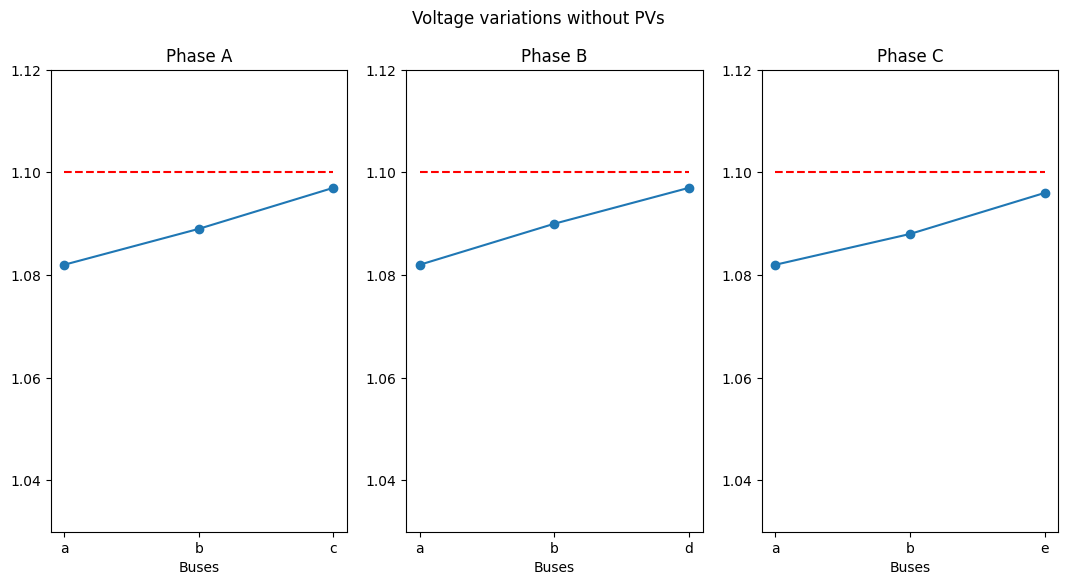

In [26]:
single_phases_buses = []
single_phase_bus_phases = []
three_phase_buses = []
all_buses = DSSCircuit.AllBusNames
for bus_name in all_buses:
    DSSCircuit.ActiveCktElement(DSSCircuit.SetActiveBus(bus_name))
    no_phases = DSSCircuit.ActiveCktElement.NumPhases
    if bus_name != "sourcebus":
        if no_phases == 3:
            three_phase_buses.append(bus_name)
        else:
            single_phases_buses.append(bus_name)
            line_name = DSSCircuit.ActiveCktElement.Name.split(".")[1]
            DSSCircuit.SetActiveElement(f"Line.{line_name}")
            bus_names = DSSCircuit.ActiveCktElement.BusNames
            single_phase_bus_phases.append(bus_names[0].split(".")[1])

all_buses = three_phase_buses + single_phases_buses
ph_a, ph_b, ph_c = [], [], []
v_ph_a, v_ph_b, v_ph_c = [], [], []
phases = ['a', 'b', 'c']

for bus_name in all_buses:
    DSSCircuit.SetActiveBus(bus_name)
    if bus_name in three_phase_buses:
        for i, ph in enumerate(phases):
            exec(f'v_ph_{ph}.append(round(DSSCircuit.ActiveBus.puVmagAngle[{2*i}], 3))')
            
    else:
        phase = int(single_phase_bus_phases[single_phases_buses.index(bus_name)])
        for i, ph in enumerate(phases):
            if phase == i+1:
                exec(f'v_ph_{ph}.append(round(DSSCircuit.ActiveBus.puVmagAngle[0], 3))')
            else:
                exec(f'v_ph_{ph}.append(0)')

for ph in phases:
    exec(f'ph_{ph} = [bus for bus in all_buses if v_ph_{ph}[all_buses.index(bus)] != 0]')
    exec(f'v_ph_{ph} = [v for v in v_ph_{ph} if v != 0]')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 6))
names = {0: "Phase A", 1: "Phase B", 2: "Phase C"}
for ph, (v, ph_buses) in enumerate(zip([v_ph_a, v_ph_b, v_ph_c], [ph_a, ph_b, ph_c])):
    axs[ph].plot(v, marker="o")
    axs[ph].plot([0, 2], [1.1, 1.1], 'r--')
    ticks = np.arange(len(v))
    axs[ph].set_xticks(ticks)
    axs[ph].set_xticklabels(ph_buses)
    axs[ph].title.set_text(f"{names[ph]}")
    axs[ph].set_xlabel("Buses",)
    axs[ph].set_ylim([1.03, 1.12])

if pv == 1:
    if pv == 1 and inv == 0:
        fig.suptitle('Voltage variations with PVs')
    else: 
        fig.suptitle('Voltage variations with PVs and inverter controls')    
else:
    fig.suptitle('Voltage variations without PVs')
plt.show()


#### 2.13.2 Plotting the power exported with and without inverter control function 

The code below shows how to present the PV systems exported power `with` and `without` inverter control function using bar plots. 

- First, all PV systems used in the current simulation are stored in the variable `pv_names`. 
- Then, their active power (P) is stored in the variable `p_export` for all PV systems in order as in `pv_names`.
- Finally, a plots is produced: 
   - Either one using the inverter control function (**if inv==1** part) 
   - Or, the one without using the control function (**else** part)


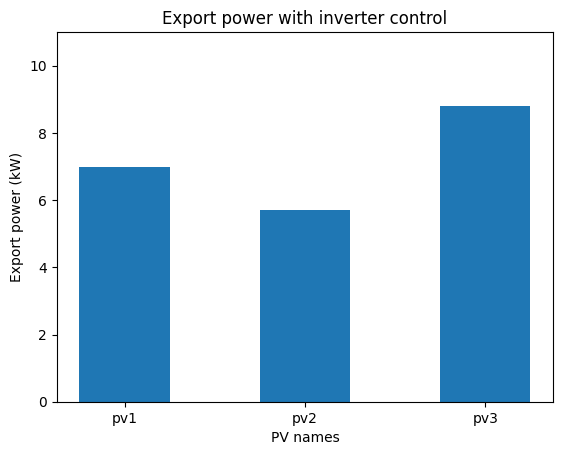

In [16]:
p_export = []
if pv == 1:
    pv_names = DSSCircuit.PVSystems.AllNames
    for pv in pv_names:
        DSSCircuit.SetActiveElement(f"PVSystem.{pv}")
        p_export.append(abs(round(DSSCircuit.ActiveElement.Powers[0], 3)))

    plt.subplots()
    plt.bar([0, 1, 2], p_export, 0.5)
    plt.xticks([0, 1, 2], pv_names)
    plt.ylim([0, 11])
    plt.xlabel("PV names")
    plt.ylabel("Export power (kW)")
    if inv == 1:
        plt.title('Export power with inverter control')
    else:
        plt.title('Export power without inverter control')
    plt.show()

## 3. Exercises

First, read all the exercises so you understand their purpose.

At the very end of this notebook in **4. Simulation Workspace**, you will be able to place all your code to run it at once. Remember, you should use **`code`** that is relevant to each exercise.

### **Exercise: PV Hosting Capacity and Volt-Watt Control using the Test LV Circuit**

In this exercise, you will use the Test LV Circuit shown below (files in the folder **`TestLVCircuit`**) and assess the effects of the Volt-Watt control function on the PV Hosting Capacity when considering different settings and seasons. To achieve this, you will also need to **modify the code** as specified in each part of the exercise.

<img style="float: middle;" src="Figure_3.png" width="60%">

**<center>Figure 3. Test LV Circuit Topology</center>**

**E.1:** Starting from 0% PV penetration, increase the penetration by 20%, up to 100% PV penetration for **each** of the given days per season (also using the pre-selected PV profile). Test the three Volt-Watt curves (settings) below and check the customer voltages and the resulting curtailment. Based on that, decide which one is the **best curve**.

   - **Summer Day: `start_day=28`**
   - **Autumn Day: `start_day=54`** 
   
- <font color='blue'>Curve 1:</font>
    - **X_array = "(0.500, 1.090, 1.100, 1.500)"**  
    - **Y_array = "(1.0, 1.0, 0.0, 0.0)"**
    
- <font color='blue'>Curve 2:</font>
    - **X_array = "(0.500, 1.095, 1.100, 1.500)"**
    - **Y_array = "(1.0, 1.0, 0.0, 0.0)"**
    
- <font color='blue'>Curve 3:</font>
    - **X_array = "(0.500, 1.095, 1.104, 1.500)"**
    - **Y_array = "(1.0, 1.0, 0.0, 0.0)"**


>- The simulations will be done only for the specified day (i.e., **`total_days=1`**).
>- This also means that the demand will be defined by selecting that day and the pre-defined random seed.
>- For each season, change the input of the `PVData30minutes` variable (the PV dataset) to be equal to the relevant PV dataset (`Residential_PV_profiles_Summer.npy` or`Residential_PV_profiles_Autumn.npy`). Each dataset contains only one PV profile so there is no need to select the PV profile.
>- Replace the Volt-Watt settings in the code of **2. Tutorial** with those of the curve you will be testing (<font color='blue'>Curve 1</font>, <font color='blue'>Curve 2</font> or <font color='blue'>Curve 3</font>).

**E.2:** Starting from 60% of PV penetration (60%, 80% and 100%) and using the **best curve only**, plot the voltage profiles of the customers **without** and **with** the Volt-Watt control function **only for the summer day**.

**E.3:** Starting from 60% of PV penetration (60%, 80% and 100%) and using the **best curve only**, plot the aggregated (total) curtailed power at 14:00h from customers PV systems **only for the summer day**.

**E.4:** Starting from 60% of PV penetration (60%, 80% and 100%) and using the **best curve only**, plot the curtailed power of the PV system as a time-series plot for the following customers: **3, 15, 30** **only for the summer day**.

**E.5:** Determine the PV Hosting Capacity when using <font color='blue'>Curve 3</font>.

## 4. Simulation Workspace